#### Importing Library

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import optuna
import matplotlib.pyplot as plt

#### Load and Preprocess Data

In [ ]:
# Using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load data
file_path = 'GOOG.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Filtering data till 2020 -> pre pandemic
data = data[data['Date'].dt.year <= 2020]

# Extracting target and train, test val dataset
values = data['Close'].values.astype('float32').reshape(-1, 1)
train_size = int(len(values) * 0.7)
val_size = int(len(values) * 0.15)
test_size = len(values) - train_size - val_size

train_data, val_data, test_data = np.split(values, [train_size, train_size + val_size])

# Scaling Data, fitting on Train Data
scaler = MinMaxScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data).flatten()
val_data_scaled = scaler.transform(val_data).flatten()
test_data_scaled = scaler.transform(test_data).flatten()

#### Dataset class

In [ ]:
# Defining  and calling the dataset for time series
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.sequence_length]
        y = self.data[idx + self.sequence_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

sequence_length = 30
train_dataset = TimeSeriesDataset(train_data_scaled, sequence_length)
val_dataset = TimeSeriesDataset(val_data_scaled, sequence_length)
test_dataset = TimeSeriesDataset(test_data_scaled, sequence_length)

#### Defining Model

In [ ]:
# GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

#### Trainning Evaluation 

In [ ]:
# Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    train_loss_list, val_loss_list = [], []
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x = x.unsqueeze(-1).to(device)  # shape: [batch, seq_len, 1]
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.unsqueeze(-1).to(device)
                y_val = y_val.to(device)
                val_output = model(x_val)
                val_loss = criterion(val_output.squeeze(), y_val)
                running_val_loss += val_loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_loss_list.append(val_loss)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    return train_loss_list, val_loss_list

def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.unsqueeze(-1).to(device)
            y_test = y_test.to(device)
            output = model(x_test)
            predictions.extend(output.squeeze().cpu().tolist())  # move to CPU for numpy ops
            targets.extend(y_test.cpu().tolist())

    # Inverse transform predictions and targets to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    targets = scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, predictions)

    return mse, mae, rmse, r2, predictions, targets


Using device: cuda


#### Hyper-parameter Optimization

In [ ]:
# Optuna Optimization
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    model_type = "GRU" 

    model = GRUModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=15)
    return min(val_loss)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

best_params = study.best_params
print("Best parameters:", best_params)

[I 2024-12-06 15:54:47,407] A new study created in memory with name: no-name-280b29bd-da79-494e-9491-8460483d5b78
[I 2024-12-06 15:55:17,427] Trial 0 finished with value: 0.0013654759225303409 and parameters: {'hidden_size': 101, 'num_layers': 1, 'learning_rate': 0.00010045826721916598, 'batch_size': 16}. Best is trial 0 with value: 0.0013654759225303409.


Early stopping at epoch 21


[I 2024-12-06 15:56:09,373] Trial 1 finished with value: 0.0006566772267310502 and parameters: {'hidden_size': 39, 'num_layers': 2, 'learning_rate': 0.004253511176000656, 'batch_size': 16}. Best is trial 1 with value: 0.0006566772267310502.


Early stopping at epoch 23


[I 2024-12-06 15:56:38,410] Trial 2 finished with value: 0.004199129563762415 and parameters: {'hidden_size': 45, 'num_layers': 2, 'learning_rate': 0.00011147172228147662, 'batch_size': 32}. Best is trial 1 with value: 0.0006566772267310502.


Early stopping at epoch 21


[I 2024-12-06 15:56:59,528] Trial 3 finished with value: 0.0014334281266201287 and parameters: {'hidden_size': 120, 'num_layers': 3, 'learning_rate': 0.006189480708611496, 'batch_size': 64}. Best is trial 1 with value: 0.0006566772267310502.


Early stopping at epoch 26


[I 2024-12-06 15:58:10,281] Trial 4 finished with value: 0.0005216121384077461 and parameters: {'hidden_size': 42, 'num_layers': 1, 'learning_rate': 0.0006914118482226465, 'batch_size': 32}. Best is trial 4 with value: 0.0005216121384077461.
[I 2024-12-06 15:59:23,232] Trial 5 finished with value: 0.0007920504040636221 and parameters: {'hidden_size': 31, 'num_layers': 2, 'learning_rate': 0.003659437390684294, 'batch_size': 32}. Best is trial 4 with value: 0.0005216121384077461.
[I 2024-12-06 16:00:26,174] Trial 6 finished with value: 0.00030711193463311677 and parameters: {'hidden_size': 118, 'num_layers': 2, 'learning_rate': 0.0003311512782384511, 'batch_size': 32}. Best is trial 6 with value: 0.00030711193463311677.
[I 2024-12-06 16:02:13,426] Trial 7 finished with value: 0.0003010531037108268 and parameters: {'hidden_size': 49, 'num_layers': 1, 'learning_rate': 0.0012392152113272585, 'batch_size': 16}. Best is trial 7 with value: 0.0003010531037108268.
[I 2024-12-06 16:03:00,005] Tr

Early stopping at epoch 38


[I 2024-12-06 16:07:24,896] Trial 11 finished with value: 0.00029079618193586737 and parameters: {'hidden_size': 67, 'num_layers': 1, 'learning_rate': 0.0022759421942944013, 'batch_size': 16}. Best is trial 10 with value: 0.0002784576519499407.
[I 2024-12-06 16:09:19,440] Trial 12 finished with value: 0.000295149608309903 and parameters: {'hidden_size': 70, 'num_layers': 1, 'learning_rate': 0.0022665964841547008, 'batch_size': 16}. Best is trial 10 with value: 0.0002784576519499407.


Early stopping at epoch 45


[I 2024-12-06 16:10:19,992] Trial 13 finished with value: 0.00032441786646125585 and parameters: {'hidden_size': 67, 'num_layers': 1, 'learning_rate': 0.009574489942719264, 'batch_size': 16}. Best is trial 10 with value: 0.0002784576519499407.


Early stopping at epoch 26


[I 2024-12-06 16:11:03,063] Trial 14 finished with value: 0.0026495786776649767 and parameters: {'hidden_size': 17, 'num_layers': 1, 'learning_rate': 0.0023711291914233624, 'batch_size': 64}. Best is trial 10 with value: 0.0002784576519499407.
[I 2024-12-06 16:12:58,401] Trial 15 finished with value: 0.00028151784991260265 and parameters: {'hidden_size': 62, 'num_layers': 1, 'learning_rate': 0.0020402948197095335, 'batch_size': 16}. Best is trial 10 with value: 0.0002784576519499407.


Early stopping at epoch 50


[I 2024-12-06 16:15:00,472] Trial 16 finished with value: 0.0003055591803638743 and parameters: {'hidden_size': 84, 'num_layers': 1, 'learning_rate': 0.0004269542151525005, 'batch_size': 16}. Best is trial 10 with value: 0.0002784576519499407.
[I 2024-12-06 16:16:17,403] Trial 17 finished with value: 0.0006723446925674137 and parameters: {'hidden_size': 59, 'num_layers': 3, 'learning_rate': 0.001629923686909066, 'batch_size': 16}. Best is trial 10 with value: 0.0002784576519499407.


Early stopping at epoch 37


[I 2024-12-06 16:16:33,464] Trial 18 finished with value: 0.0010391232106485404 and parameters: {'hidden_size': 85, 'num_layers': 2, 'learning_rate': 0.0004812279922314794, 'batch_size': 64}. Best is trial 10 with value: 0.0002784576519499407.


Early stopping at epoch 21


[I 2024-12-06 16:18:26,484] Trial 19 finished with value: 0.00038502908687774296 and parameters: {'hidden_size': 104, 'num_layers': 1, 'learning_rate': 0.00021933377008475694, 'batch_size': 16}. Best is trial 10 with value: 0.0002784576519499407.
[I 2024-12-06 16:18:56,003] Trial 20 finished with value: 0.00029491397627508204 and parameters: {'hidden_size': 58, 'num_layers': 1, 'learning_rate': 0.003925787754358296, 'batch_size': 16}. Best is trial 10 with value: 0.0002784576519499407.


Early stopping at epoch 33


[I 2024-12-06 16:19:25,180] Trial 21 finished with value: 0.00028127391694421957 and parameters: {'hidden_size': 77, 'num_layers': 1, 'learning_rate': 0.002048315176385256, 'batch_size': 16}. Best is trial 10 with value: 0.0002784576519499407.


Early stopping at epoch 49


[I 2024-12-06 16:19:57,808] Trial 22 finished with value: 0.0002733962132510528 and parameters: {'hidden_size': 78, 'num_layers': 1, 'learning_rate': 0.0015391992048737792, 'batch_size': 16}. Best is trial 22 with value: 0.0002733962132510528.
[I 2024-12-06 16:20:29,551] Trial 23 finished with value: 0.0002777896217004446 and parameters: {'hidden_size': 79, 'num_layers': 1, 'learning_rate': 0.001278083993048313, 'batch_size': 16}. Best is trial 22 with value: 0.0002733962132510528.
[I 2024-12-06 16:20:49,855] Trial 24 finished with value: 0.00026262997596711865 and parameters: {'hidden_size': 99, 'num_layers': 1, 'learning_rate': 0.001390510662704508, 'batch_size': 16}. Best is trial 24 with value: 0.00026262997596711865.


Best parameters: {'hidden_size': 99, 'num_layers': 1, 'learning_rate': 0.001390510662704508, 'batch_size': 16}


#### Training the model with Best-Parameters

Early stopping at epoch 52
MSE: 3.0658, MAE: 1.3171, RMSE: 1.7509, R²: 0.9708


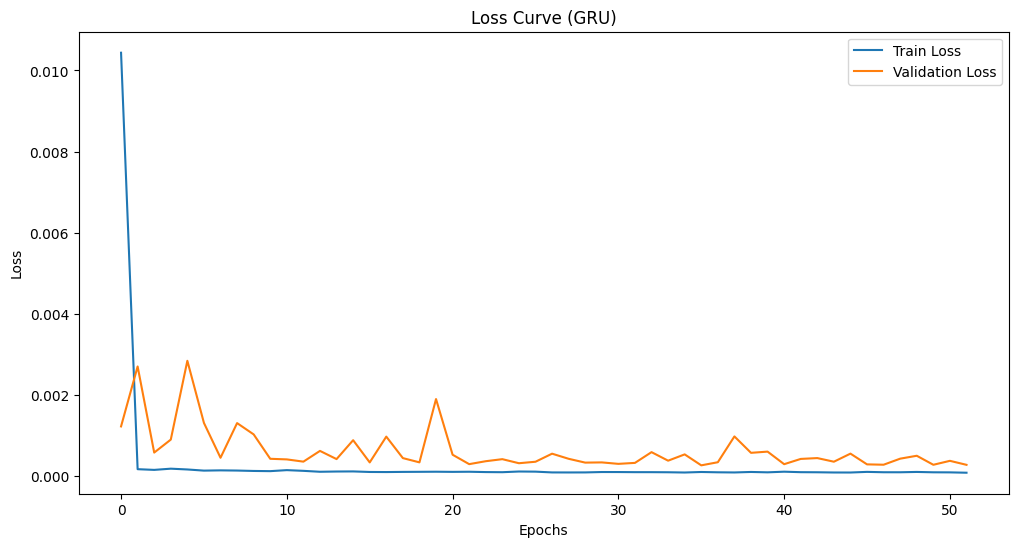

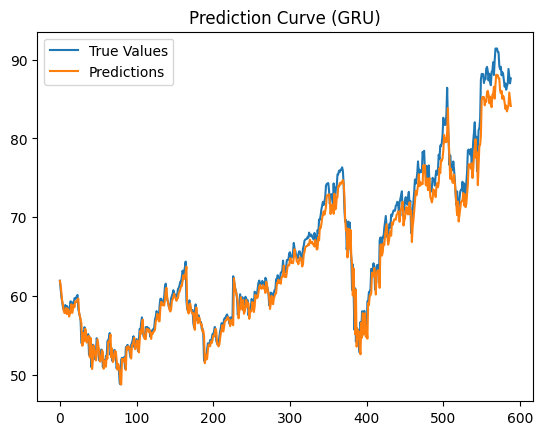

In [ ]:
# Final Training with Best Parameters
model_type = "GRU"

final_model = GRUModel(input_size=1, hidden_size=best_params["hidden_size"], num_layers=best_params["num_layers"]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])

final_batch_size = best_params["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=final_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=final_batch_size)
test_loader = DataLoader(test_dataset, batch_size=final_batch_size)

train_loss, val_loss = train_model(final_model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=15)

mse, mae, rmse, r2, predictions, targets = evaluate_model(final_model, test_loader)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title(f"Loss Curve ({model_type})")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot predictions vs targets
plt.figure()
plt.plot(targets, label='True Values')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.title(f"Prediction Curve ({model_type})")
plt.show()
